## Тема: «Модели машинного обучения для анализа датасетов валютных курсов с высокой частотой дискретизации»

## Выполнила: Подшивалова Анастасия

**Цель работы: исследование и реализация различных методов машинного обучения, применимых для анализа валютных курсов с высокой частотой дискретизации**

**Задачи:**
1. Сбор всех необходимых данных о валютных курсах;
2. Описание и подготовка данных для дальнейшего анализа;
3. Построение моделей машинного обучения;
4. Оценка показателей качества полученных моделей и их сравнение;
5. Анализ результатов.

**Ожидаемый результат:**\
Модель машинного обучения, наиболее эффективная в анализе и прогнозировании валютных курсов.

**Описание датасета:**\
В датасете представлены данные о валютных парах, цена за 1 евро в долларах США, с частотой свечей 10 минут. 

## Этап сбора данных

In [29]:
# импортируем все нужные библиотеки
import gzip
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.svm import SVC

In [2]:
# См. https://github.com/Tim55667757/MT4ForexParser/blob/master/mt4forexparser/MT4ForexParser.py

def read_hst_gz(filename: str) -> pd.DataFrame:
    with gzip.open(filename) as f:
        version = np.frombuffer(f.read(148)[:4], 'i4')
        if version == 400:
            dtype = [
                ('unix', 'u4'), ('open', 'f8'),
                ('high', 'f8'), ('low', 'f8'),
                ('close', 'f8'), ('volume', 'u8')
            ]
        elif version == 401:
            dtype = [
                ('unix', 'u8'), ('open', 'f8'),
                ('high', 'f8'), ('low', 'f8'),
                ('close', 'f8'), ('volume', 'u8'),
                ('s', 'i4'), ('r', 'i8')
            ]
        else:
            raise NotImplementedError(f'unsupported format version: {version}')
        d = pd.DataFrame(np.frombuffer(f.read(), dtype=dtype))
        d['datetime'] = pd.to_datetime(d.unix, unit='s')
    
        if version == 401:
            d.drop(columns=['s', 'r'], inplace=True)
        return d

In [3]:
# ссылка для скачивания датасета:
# https://github.com/FX-Data/FX-Data-EURUSD-DS/releases/download/2021/EURUSD10.hst.gz

d = read_hst_gz("EURUSD10.hst.gz")
d

,unix,open,high,low,close,volume,datetime
0,1609711200,1.22396,1.22420,1.22296,1.22322,365,2021-01-03 22:00:00
1,1609711850,1.22310,1.22365,1.22309,1.22356,288,2021-01-03 22:10:50
2,1609712401,1.22356,1.22387,1.22341,1.22370,850,2021-01-03 22:20:01
3,1609713000,1.22367,1.22400,1.22325,1.22354,1481,2021-01-03 22:30:00
4,1609713610,1.22353,1.22367,1.22336,1.22343,207,2021-01-03 22:40:10
...,...,...,...,...,...,...,...
36840,1640905801,1.13223,1.13256,1.13218,1.13250,323,2021-12-30 23:10:01
36841,1640906402,1.13252,1.13257,1.13245,1.13245,186,2021-12-30 23:20:02
36842,1640907000,1.13245,1.13248,1.13189,1.13204,268,2021-12-30 23:30:00
36843,1640907613,1.13204,1.13226,1.13194,1.13226,165,2021-12-30 23:40:13


Мы взяли датасет с названием EURUSD10, это значит, что наш период равен 10 минутам. Цифра в названии обозначает именно это.

Далее, в столбце unix находится значение о количестве секунд, прошедших с 1970-01-01,
таким образом в файле хранятся дата и время.

Столбцы нашего датафрейма open, close представляют собой цены на начало и конец периода. (10 минут в нашем случае)
high, low — максимальная и минимальная цены за период.

Дата/время указывают на начало периода.

volume — объем сделок за период.

In [4]:
d.shape[0] / 6 / 24 # здесь мы посчитали примерное количество дней, за которое имеем данные.

255.86805555555554

## Этап описания и подготовки данных

In [5]:
d.isnull().sum()

unix        0
open        0
high        0
low         0
close       0
volume      0
datetime    0
dtype: int64

Здесь мы проверяем наши данные на наличие пропусков и видим, что пропусков нет

In [6]:
d.describe() # проводим описательную статистику данных

,unix,open,high,low,close,volume
count,3.684500e+04,36845.000000,36845.000000,36845.00000,36845.000000,36845.000000
mean,1.625314e+09,1.182850,1.183077,1.18262,1.182847,1396.784801
std,9.075352e+06,0.028168,0.028177,0.02816,0.028168,1340.156202
min,1.609711e+09,1.118750,1.119260,1.11859,1.118770,4.000000
25%,1.617574e+09,1.164620,1.164830,1.16440,1.164600,523.000000
50%,1.625434e+09,1.185300,1.185530,1.18506,1.185300,1029.000000
75%,1.633121e+09,1.207710,1.207930,1.20750,1.207710,1828.000000
max,1.640908e+09,1.234670,1.234940,1.23440,1.234680,22141.000000


В данном случае, из описательной статистики можно заметить, что максимальные и минимальные значения параметров не сильно выбиваются из общей картины, а также медианные значения близки к средним.

Для оценки выбросов используем метод стандартного отклонения.
Выбросами считаются значения, выходящие за пределы интервала [mean - k*std, mean + k*std], где mean и std - среднее значение и стандартное отклонение соответственно, а k - коэффициент равный 3.

In [7]:
# Определяем параметры для анализа
params = ['open', 'high', 'low', 'close', 'volume']

for param in params:
    mean = d[param].mean()
    std = d[param].std()
    
    # Вычисляем границы интервала
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std
    
    # Выбираем значения, которые лежат за пределами интервала
    outliers = d[(d[param] > upper_bound) | (d[param] < lower_bound)]
    
    # Выводим результаты анализа для данного параметра
    print(f"Выбросы для параметра {param}:")

    display(outliers)

Выбросы для параметра open:


,unix,open,high,low,close,volume,datetime


Выбросы для параметра high:


,unix,open,high,low,close,volume,datetime


Выбросы для параметра low:


,unix,open,high,low,close,volume,datetime


Выбросы для параметра close:


,unix,open,high,low,close,volume,datetime


Выбросы для параметра volume:


,unix,open,high,low,close,volume,datetime
62,1609748400,1.22707,1.22732,1.22662,1.22722,5706,2021-01-04 08:20:00
99,1609770600,1.23063,1.23079,1.22899,1.22933,9163,2021-01-04 14:30:00
100,1609771200,1.22932,1.23041,1.22928,1.22983,5947,2021-01-04 14:40:00
101,1609771800,1.22984,1.23009,1.22836,1.22892,9754,2021-01-04 14:50:00
102,1609772400,1.22892,1.22908,1.22741,1.22749,8435,2021-01-04 15:00:00
...,...,...,...,...,...,...,...
36248,1640377800,1.13147,1.13156,1.13050,1.13121,15133,2021-12-24 20:30:00
36249,1640378400,1.13125,1.13133,1.13050,1.13075,6198,2021-12-24 20:40:00
36250,1640379001,1.13078,1.13206,1.13057,1.13138,7507,2021-12-24 20:50:01
36254,1640381400,1.13156,1.13263,1.13151,1.13207,5670,2021-12-24 21:30:00


Для параметра volume были выявлены некоторые выбросы. \
Может быть, это связано с некоторыми важными событиями на рынке или новостями, которые повлияли на объем торгов. 

### Визуализация распределения признаков

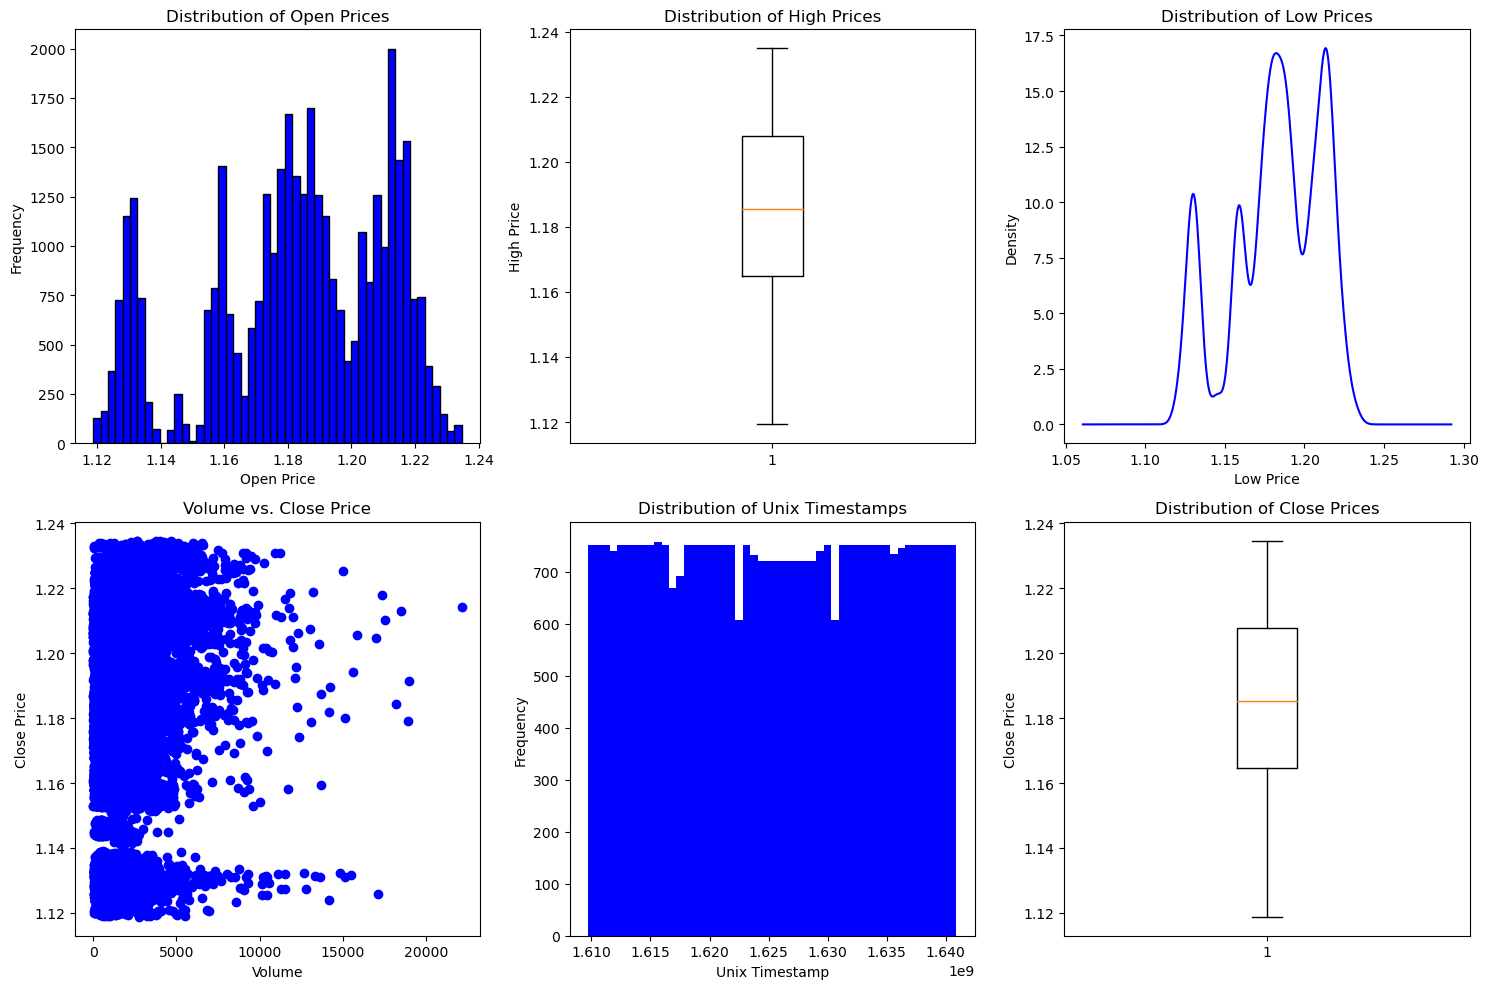

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

# Строим гистограмму для столбца "open"
axes[0,0].hist(d["open"], bins=50, color = 'blue', edgecolor = 'black')
axes[0,0].set_title("Distribution of Open Prices")
axes[0,0].set_xlabel("Open Price")
axes[0,0].set_ylabel("Frequency")

# Строим ящик с усами для столбца "high"
axes[0,1].boxplot(d["high"])
axes[0,1].set_title("Distribution of High Prices")
axes[0,1].set_ylabel("High Price")

# Строим график плотности распределения для столбца "low"
d["low"].plot(kind="kde", ax=axes[0,2], color = 'blue')
axes[0,2].set_title("Distribution of Low Prices")
axes[0,2].set_xlabel("Low Price")

# Строим диаграмму рассеяния, которая отображает зависимость столбца "volume" от значений столбца"close" 
axes[1,0].scatter(d["volume"], d["close"], color = 'blue')
axes[1,0].set_title("Volume vs. Close Price")
axes[1,0].set_xlabel("Volume")
axes[1,0].set_ylabel("Close Price")

#Строим гистограмму для "unix"
axes[1,1].hist(d["unix"], bins=50, color = 'blue')
axes[1,1].set_title("Distribution of Unix Timestamps")
axes[1,1].set_xlabel("Unix Timestamp")
axes[1,1].set_ylabel("Frequency")

# Строим ящик с усами для "close" 
axes[1,2].boxplot(d["close"])
axes[1,2].set_title("Distribution of Close Prices")
axes[1,2].set_ylabel("Close Price")

plt.tight_layout()
plt.show()

In [7]:
target_col = 'close'
corr_matrix = d.corrwith(d[target_col])

print("Корреляция каждого признака с целевой переменной:")
print(corr_matrix)

Корреляция каждого признака с целевой переменной:
unix     -0.868579
open      0.999924
high      0.999960
low       0.999961
close     1.000000
volume    0.175377
dtype: float64


Из полученных значений видно, что целевая переменная "close" имеет очень высокую положительную корреляцию со столбцами "open", "high" и "low", что говорит о том, что эти признаки могут быть хорошими предикторами целевой переменной в модели машинного обучения.

Обратная корреляция между "unix" и "close" может указывать на то, что цены на активы в определенное время дня или в определенные дни недели имеют свои специфические значения, которые могут повлиять на изменение цены закрытия.

### Матрица корреляции

<AxesSubplot:>

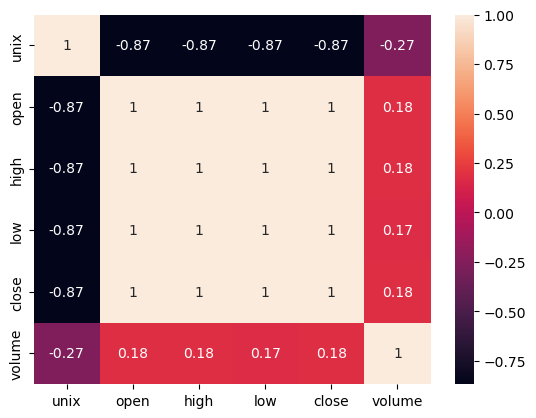

In [10]:
corr_matrix = d.corr()
sns.heatmap(corr_matrix, annot=True)

Столбцы `open`, `high`, `low` и `close` имеют очень сильную положительную корреляцию между собой, что весьма ожидаемо, поскольку эти столбцы представляют различные цены на актив в течение дня.

`Volume` имеет достаточно низкую корреляцию с остальными переменными, что может говорить о том, что объем торгов не является сильным фактором влияния на цену. Однако это не обязательно означает, что данный признак не может быть полезным в моделировании цены, и его следует рассмотреть в контексте других признаков и выбранной модели.

## Построение моделей и оценка показателей качества полученных моделей

Прежде чем понять, какая же модель будет наиболее подходящей, нам нужно построить несколько моделей и сделать выводы.\
Для начала построим модель линейной регрессии и посмотрим, как она описывает наши данные.

### Линейная регрессия

In [8]:
# Определяем целевую переменную и признаки
target_col = "close"
feature_cols = ["open", "high", "low", "volume"]

# Разделяем данные на обучающую и тестовую выборки
train_data, test_data, train_target, test_target = train_test_split(
    d[feature_cols], d[target_col], test_size=0.2, random_state=42
)

# Стандартизируем данные
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Измеряем время перед началом обучения модели
start_time = time.time()

# Обучаем модель линейной регрессии
model = LinearRegression()
model.fit(train_data_scaled, train_target)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оцениваем качество модели на тестовой выборке
score = model.score(test_data_scaled, test_target)
print(f"Коэффициент детерминации: {score}")

# Предсказываем значения на тестовой выборке
predictions = model.predict(test_data_scaled)

print("Предсказанные значения:")
display(pd.DataFrame(test_data, columns=feature_cols).assign(**{
    "close": np.array(test_target),
    "close_pred": predictions,
    "error": np.array(test_target) - predictions,
}).round(5))

Время обучения модели: 0.17
Коэффициент детерминации: 0.9999697965291199
Предсказанные значения:


,open,high,low,volume,close,close_pred,error
2761,1.21061,1.21091,1.21055,1171,1.21077,1.21080,-0.00003
2532,1.21164,1.21196,1.21123,2810,1.21129,1.21157,-0.00028
35975,1.13232,1.13262,1.13222,728,1.13236,1.13248,-0.00012
12891,1.21616,1.21687,1.21605,1720,1.21651,1.21663,-0.00012
12848,1.21552,1.21562,1.21545,646,1.21561,1.21554,0.00007
...,...,...,...,...,...,...,...
28798,1.15976,1.15977,1.15964,154,1.15973,1.15967,0.00006
1148,1.21558,1.21575,1.21534,458,1.21558,1.21552,0.00006
3547,1.20292,1.20338,1.20230,3235,1.20244,1.20279,-0.00035
28938,1.15970,1.15982,1.15969,171,1.15982,1.15979,0.00003


Коэффициент детерминации является мерой качества модели и означает, какую долю изменчивости зависимой переменной (в данном случае, курс валюты при закрытии) можно объяснить с помощью независимых переменных (в данном случае, времени и цены на открытие, максимум, минимум и закрытие).

Значение коэффициента детерминации в нашем случае равно 0.99997, что говорит о том, что построенная модель очень хорошо объясняет изменчивость курса валюты. Это высокое значение означает, что 99,997% изменчивости курса валюты может быть объяснено с помощью независимых переменных, использованных в модели.

In [9]:
# 1360% годовых без риска.
(d.high - d.low).sum() / d.open.max()

13.61399402269432

Теперь построим диаграмму рассеяния фактических и предсказанных значений, чтобы визуально увидеть отклонения.

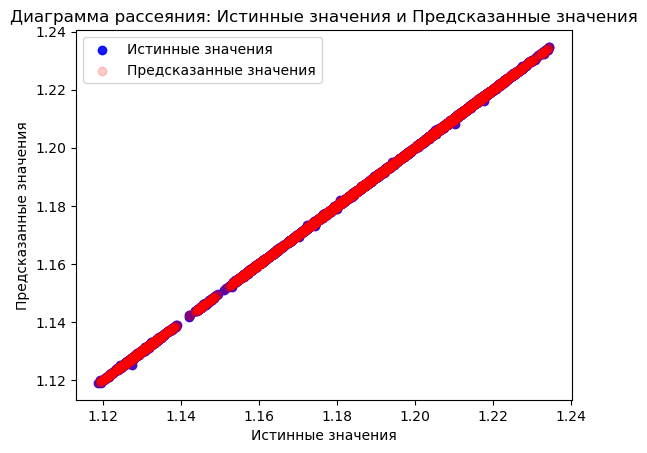

In [21]:
fig, ax = plt.subplots()

# Рисуем точки для истинных значений
ax.scatter(test_target, predictions, color='blue', alpha=0.9, label='Истинные значения')

# Рисуем точки для предсказанных значений
ax.scatter(test_target, predictions, color='red', alpha=0.2, label='Предсказанные значения')

ax.set_title("Диаграмма рассеяния: Истинные значения и Предсказанные значения")
ax.set_xlabel("Истинные значения")
ax.set_ylabel("Предсказанные значения")

ax.legend()
plt.show()

На этом графике и фактические и предсказанные значения почти что накладываются друг на друга. Это происходит потому, что метрики модели очень высокие, соответственно, точность предсказания тоже высокая.

Глядя на показатели модели и диаграмму рассеяния фактических и предсказанных значений, кажется, что эта модель идеально описывает наши данные.\
Но это не совсем так. Сейчас мы рассмотрим недостатки этой модели.

Проблема модели заключается в том, что она предсказывает закрытие цены при известном \
максимуме и минимуме. Ее максимальная ошибка — это расстояние между \
`high` и `low`. \
\
На практике это не применимо.

Предположим, что у нас есть информация о цене открытия, минимальной и максимальной ценах за день. Если мы будем ориентироваться только на эти данные, то сможем принимать только два решения: покупать или продавать, в зависимости от того, достигнут ли максимальный или минимальный уровень цены.\
\
Это нереалистичные предположения, а модель нам никак не пригодилась.\
В реальной жизни, цена на финансовых рынках зависит от множества факторов, которые не учитываются в данной модели.

### Метод опорных векторов (SVM)

Предсказать цену на практике будет достаточно сложно, и показатели часто будут нереалистичными. Попробуем предсказать направление движения цены.\
\
Такая модель будет принимать на вход исторические данные о цене и объеме торгов, а затем пытаться предсказать, будет ли цена повышаться или понижаться в следующем периоде времени. Такой подход более реалистичен с точки зрения торговли на финансовых рынках. Это будет полезно при принятии решения о том, когда покупать или продавать активы.

Для начала попробуем построить модель на основе метода опорных векторов.\
Она будет использовать SVM для классификации, то есть для прогнозирования двух возможных значений цены: рост или падение.

In [23]:
d2 = d.copy()

# Определение направления движения цены
d2['direction'] = (d2['close'] - d2['open']).apply(lambda x: 1 if x > 0 else 0)

# Создание признаков
d2['open_shifted'] = d2['open'].shift(1)
d2['high_shifted'] = d2['high'].shift(1)
d2['low_shifted'] = d2['low'].shift(1)
d2['close_shifted'] = d2['close'].shift(1)
d2['volume_shifted'] = d2['volume'].shift(1)
d2['direction_shifted'] = d2['direction'].shift(1)

Входными данными для модели являются ценовые данные актива, такие как открытие, максимальная и минимальная цены, закрытие и объем торгов. Эти данные используются для создания признаков (open_shifted, high_shifted, low_shifted, close_shifted, volume_shifted), которые будут использоваться для обучения модели.

In [ ]:
# Удаление строк с пропущенными значениями
d2.dropna(inplace=True)

In [24]:
# Определение X и y
X = d2[['open_shifted', 'high_shifted', 'low_shifted', 'close_shifted', 'volume_shifted']]
y = d2['direction_shifted']

# Разделение данных на обучающую и тестовую выборки
split_index = int(0.7 * len(d2))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Масштабирование данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели SVM
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = svm.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = svm.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 67.02
Accuracy: 0.5257825221639225
Precision: 0.954248366013072
Recall: 0.02713250325218361
F1-score: 0.052764727141308275


Исходя из этих метрик можно сделать вывод, что модель является достаточно неточной в предсказании направления движения цены. 

Recall (полнота) показывает, какую долю объектов положительного класса модель способна обнаружить. В данном случае, recall равен 0.027, что означает, что из всех реальных положительных классов (движение цены "вверх"), модель способна обнаружить только 2.7%. Это очень низкий показатель.

Модель не может точно идентифицировать периоды, когда цена на рынке будет двигаться вверх. Низкий recall может привести к упущению возможности получения прибыли при торговле на рынке, поскольку модель не будет сигнализировать об изменении направления движения цены в нужный момент.

Низкое значение F1-меры также говорит нам о том, что эта модель не применима на практике. Она указывает на низкую сбалансированность модели между точностью и полнотой.

Теперь попробуем построить другие модели классификации, чтобы сравнить их показатели и выбрать самую оптимальную из них.

### Случайный лес (Random Forest)

In [25]:
# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели случайного леса
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = rfc.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = rfc.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 4.43
Accuracy: 0.5255586718537953
Precision: 0.5398593200468933
Recall: 0.17118959107806692
F1-score: 0.25994919559695173


Если сравнивать эту модель с предыдущей, то мы можем заметить, что precision у модели на основе случайного леса заметно упал. Следовательно, из всех предсказанных моделью положительных классов 54% действительно являются положительными. Но при этом recall ощутимо повысился. Accuracy по-прежнему невысокая, F1-score = 0.26, это уже лучше, чем метрика для модели на основе метода опорных векторов, но все еще недостаточно для того, чтобы мы смогли в дальнейшем использовать эту модель.

### Градиентный бустинг (Gradient Boosting)

In [30]:
# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели градиентного бустинга
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = gb.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = gb.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 8.87
Accuracy: 0.541662896951054
Precision: 0.8312236286919831
Recall: 0.07323420074349442
F1-score: 0.13460881448582165


Эта модель по своим показателям схожа с моделью, построенной на основе метода опорных векторов. Она хорошо показывает, какая доля положительных предсказаний модели действительно является верными, но также имеет низкую способность обнаруживать и правильно классифицировать положительные примеры.

Модель градиентного бустинга также показывает недостаточно высокую точность и полноту в предсказании направления движения цены.

### K-ближайших соседей (KNN)

In [34]:
# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели KNN
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time

# Оценка точности модели
accuracy = knn.score(X_test_scaled, y_test)

# Предсказание направления движения цены на тестовом наборе данных
y_pred = knn.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

C:\Users\podsh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\podsh\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [35]:
print(f"Время обучения модели: {train_time:.2f}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 0.03
Accuracy: 0.51931602279924
Precision: 0.5035141088849261
Recall: 0.8921933085501859
F1-score: 0.6437336552001609


Модель KNN обучается быстрее всех предыдущих моделей и имеет лучшие показатели. В целом, модель KNN может быть полезной для обнаружения положительных примеров, но требует дальнейшего улучшения для достижения более высокой точности и precision. Но мы рассмотрим еще несколько моделей.

### Дерево принятия решений (Decision Tree)

In [38]:
# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели дерева принятия решений
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = dt.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = dt.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 2.94
Accuracy: 0.5375011309146838
Precision: 0.521640826873385
Recall: 0.6003717472118959
F1-score: 0.5582440373314898


Модель Decision Tree хуже описывает наши данные, чем предыдущая модель KNN. Поэтому в дальнейшее рассмотрение мы её не включаем.

### Наивный Байесовский классификатор (Naive Bayes)

In [39]:
# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели наивного Байесовского классификатора
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = nb.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = nb.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 0.01
Accuracy: 0.5114448566000181
Precision: 0.4375
Recall: 0.013011152416356878
F1-score: 0.025270758122743684


Модель Naive Bayes, несмотря на самую высокую скорость обучения, показывает самые низкие результаты. Она не способна правильно определять принадлежность объектов к классу.

### Логистическая регрессия

Теперь попробуем предсказать направление движения цены с помощью логистической регрессии.

Логистическая регрессия, как и предыдущие модели, позволяет моделировать вероятность отнесения объекта к определенному классу, в данном случае, вероятность того, что цена будет двигаться вверх или вниз.

In [40]:
# Определение направления движения цены
d2['direction'] = (d2['close'] - d2['open']).apply(lambda x: 1 if x > 0 else 0)

# Создание признаков
d2['open_shifted'] = d2['open'].shift(1)
d2['high_shifted'] = d2['high'].shift(1)
d2['low_shifted'] = d2['low'].shift(1)
d2['close_shifted'] = d2['close'].shift(1)
d2['volume_shifted'] = d2['volume'].shift(1)
d2['direction_shifted'] = d2['direction'].shift(1)

# Удаление строк с пропущенными значениями
d2.dropna(inplace=True)

# Определение X и y
X = d2[['open_shifted', 'high_shifted', 'low_shifted', 'close_shifted', 'volume_shifted']]
y = d2['direction_shifted']

# Разделение данных на обучающую и тестовую выборки
split_index = int(0.7 * len(d2))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

# Масштабирование данных
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Измеряем время перед обучением модели
start_time = time.time()

# Обучение модели логистической регрессии
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

# Измеряем время после завершения обучения модели
end_time = time.time()
train_time = end_time - start_time
print(f"Время обучения модели: {train_time:.2f}")

# Оценка точности модели
accuracy = lr.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = lr.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Время обучения модели: 0.10
Accuracy: 0.779607346421786
Precision: 0.9919786096256684
Recall: 0.5516728624535316
F1-score: 0.7090301003344482


Модель логистической регрессии, обученная на признаках, основанных на предыдущих значениях цены и объема торгов, показывает точность примерно 78%, что является довольно неплохим результатом. 

Значение метрики F1-score (гармоническое среднее между precision и recall) составляет примерно 0.71, таким образом, можно сделать вывод, что построенная модель логистической регрессии может быть полезной для предсказания направления движения цены.

К тому же, если сравнивать время обучения всех моделей, модель логистической регрессии показала неплохой результат. Показатели модели логистической регрессии намного лучше, чем у построенных ранее моделей. Таким образом, далее, для анализа, мы будем использовать именно эту модель.

Теперь для наглядности построим и выведем таблицу с предсказанными и реальными значениями, а также добавим столбец с ошибкой.

In [16]:
print("Предсказанные значения:")
display(pd.DataFrame(X_test, columns=X.columns).assign(**{
    "close_shifted": np.array(y_test),
    "close_pred": y_pred,
    "error": np.array(y_test) - y_pred,
}).head(30).round(5))

# Прогноз направления движения цены
X_pred = d2[['open_shifted', 'high_shifted', 'low_shifted', 'close_shifted', 'volume_shifted']].tail(1)
X_pred_scaled = scaler.transform(X_pred)
y_pred = lr.predict(X_pred_scaled)
if y_pred == 1:
    print("Предсказание: Рынок растет")
else:
    print("Предсказание: Рынок падает")

Предсказанные значения:


,open_shifted,high_shifted,low_shifted,close_shifted,volume_shifted,close_pred,error
25791,1.18082,1.18113,1.18076,1.0,800.0,1.0,0.0
25792,1.18108,1.18119,1.18087,0.0,745.0,0.0,0.0
25793,1.18088,1.18101,1.18076,0.0,743.0,0.0,0.0
25794,1.18082,1.18083,1.18036,0.0,935.0,0.0,0.0
25795,1.18070,1.18085,1.18052,1.0,622.0,0.0,1.0
25796,1.18081,1.18090,1.18072,0.0,697.0,0.0,0.0
25797,1.18076,1.18096,1.18066,0.0,532.0,0.0,0.0
25798,1.18068,1.18068,1.18043,0.0,560.0,0.0,0.0
25799,1.18055,1.18063,1.18047,1.0,634.0,0.0,1.0
25800,1.18062,1.18078,1.18056,0.0,348.0,0.0,0.0


Предсказание: Рынок растет


Здесь `close_shifted` - это реальное направление движения цены, а `close_pred` - предсказанное.

Для визуальной оценки качества бинарной классификации построим ROC кривую, которая описывает взаимосвязь между чувствительностью модели (TPR, или true positives rate — доля истинно положительных примеров) и её специфичностью (описываемой в отношении долей ложноположительных результатов: 1-FPR).

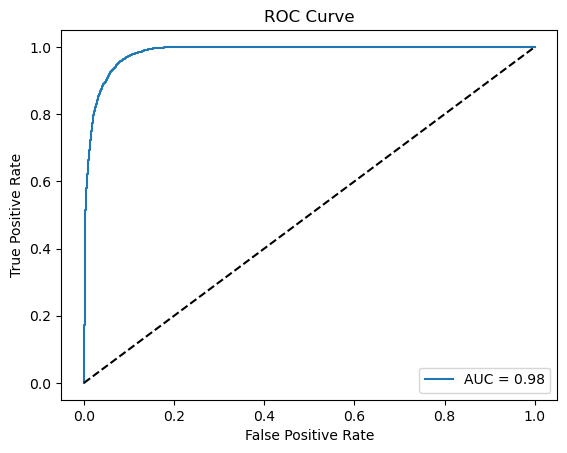

In [65]:
# Вычисление вероятностей принадлежности к положительному классу
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

# Вычисление FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Вычисление площади под ROC-кривой (AUC)
auc = roc_auc_score(y_test, y_prob)

# Построение ROC-кривой
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Площадь под ROC-кривой (AUC) является мерой качества классификатора: чем больше AUC, тем лучше качество классификации.\
\
Значение AUC = 0.5 соответствует случайному угадыванию.\
Значения AUC выше 0.5 обычно считаются лучшими, чем случайное угадывание, а значение 1.0 соответствует идеальному предсказанию.\
\
Следовательно, наша модель на тестовой выборке ведет себя намного лучше, чем случайный выбор.

Теперь оценим качество построенной модели методом кросс-валидации.

Оценка качества модели методом кросс-валидации позволяет получить более объективную оценку ее эффективности на новых данных, чем оценка на одном тестовом наборе. При кросс-валидации данные разбиваются на несколько частей, и каждая часть по очереди используется для тестирования модели, а оставшиеся части для ее обучения. Таким образом, каждый элемент данных используется и для обучения, и для тестирования модели, и результаты оценки качества усредняются по всем частям. Это позволяет получить более надежные оценки качества модели.

In [17]:
scores = cross_val_score(lr, X_train_scaled, y_train, cv=7)

print(f"Средняя оценка: {scores.mean()}")
print(f"Стандартное отклонение: {scores.std()}")

Средняя оценка: 0.7402051147031458
Стандартное отклонение: 0.041746782965109544


Средняя оценка качества модели на кросс-валидации равна 0.74. Это достаточно высокий показатель для прогнозирования направления движения цены.\
   \
Стандартное отклонение оценок равно 0.041, это говорит о том, что точность модели может варьироваться в зависимости от выборки данных. В целом, полученные результаты свидетельствуют о том, что с этой моделью можно работать.

Не будем судить о качестве модели опираясь только на полученные метрики. В реальности все будет выглядеть иначе. Поэтому проверим наши предсказания на практике, для этого создадим условия торгов на финансовом рынке с использованием нашей модели.

Проверим нашу модель для начала на данных за одни сутки с 2021-04-22 (22:10:00) по 2021-04-23 (22:10:00).

In [41]:
dd = d2.loc[(d2['datetime'] >= '2021-04-22 22:10:00') & (d2['datetime'] <= '2021-04-23 22:10:00')]

# Создание датафрейма с ценами и временными отметками
d3 = pd.DataFrame({'time': dd['datetime'], 'close': dd['close']})

Возьмем несколько свечей, за 3 часа, за 2.5 часа, за 2 часа, за 1.5 часа, за 1 час, 50 минут, 40 минут, ..., 10 минут до текущей свечи. И посчитаем изменение цены с этих свечей к текущему моменту.

Далее возьмем свечу через 3 часа. Сохраним разницу ее цены с текущей свечкой - это будет направление цены через 3 часа. Направление (1, 0) будет таргетом. А признаками будут изменения цены за прошедшие 3 часа, выше. 

In [42]:
# Создание признаков - изменение цены с прошлых свечей
d3['change_3h'] = (d3['close'] - d3['close'].shift(18)) / d3['close'].shift(18)
d3['change_2.5h'] = (d3['close'] - d3['close'].shift(15)) / d3['close'].shift(15)
d3['change_2h'] = (d3['close'] - d3['close'].shift(12)) / d3['close'].shift(12)
d3['change_1.5h'] = (d3['close'] - d3['close'].shift(9)) / d3['close'].shift(9)
d3['change_1h'] = (d3['close'] - d3['close'].shift(6)) / d3['close'].shift(6)
d3['change_50min'] = (d3['close'] - d3['close'].shift(5)) / d3['close'].shift(5)
d3['change_40min'] = (d3['close'] - d3['close'].shift(4)) / d3['close'].shift(4)
d3['change_30min'] = (d3['close'] - d3['close'].shift(3)) / d3['close'].shift(3)
d3['change_20min'] = (d3['close'] - d3['close'].shift(2)) / d3['close'].shift(2)
d3['change_10min'] = (d3['close'] - d3['close'].shift(1)) / d3['close'].shift(1)

# Добавление столбца с изменением цены через 3 часа
d3['change'] = d3['close'].shift(-18) - d3['close']

# Определение направления движения цены через 3 часа
d3['direction_3h'] = np.where(d3['close'].shift(-18) > d3['close'], 1, 0)
d3.dropna(inplace=True)

In [39]:
d3

,time,close,change_3h,change_2.5h,change_2h,change_1.5h,change_1h,change_50min,change_40min,change_30min,change_20min,change_10min,change,direction_3h
11244,2021-04-23 01:10:27,1.20223,0.000574,0.000624,0.000574,0.000741,0.000391,0.000333,0.000383,0.000708,0.000158,0.000208,0.00016,1
11245,2021-04-23 01:20:00,1.20219,0.000508,0.000583,0.000549,0.000633,0.000300,0.000349,0.000674,0.000125,0.000175,-0.000033,0.00019,1
11246,2021-04-23 01:30:01,1.20230,0.000724,0.000583,0.000633,0.000558,0.000441,0.000766,0.000216,0.000266,0.000058,0.000091,0.00013,1
11247,2021-04-23 01:40:00,1.20223,0.000624,0.000574,0.000741,0.000391,0.000708,0.000158,0.000208,0.000000,0.000033,-0.000058,0.00036,1
11248,2021-04-23 01:50:00,1.20253,0.000866,0.000832,0.000916,0.000582,0.000408,0.000458,0.000250,0.000283,0.000191,0.000250,0.00013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11340,2021-04-23 17:10:05,1.20791,0.001808,0.002207,0.001883,0.000787,0.000538,0.000688,0.000787,0.000456,0.000199,0.000364,0.00155,1
11341,2021-04-23 17:20:01,1.20794,0.001634,0.002498,0.001426,0.000928,0.000712,0.000812,0.000480,0.000224,0.000389,0.000025,0.00165,1
11342,2021-04-23 17:30:00,1.20826,0.002007,0.002298,0.001783,0.000870,0.001077,0.000745,0.000489,0.000654,0.000290,0.000265,0.00139,1
11343,2021-04-23 17:40:10,1.20831,0.002539,0.002215,0.001119,0.000870,0.000787,0.000530,0.000696,0.000331,0.000306,0.000041,0.00122,1


Теперь применим модель логистической регрессии к полученному DataFrame, обучим ее и выведем метрики.

In [43]:
X = d3[['change_3h', 'change_2.5h', 'change_2h', 'change_1.5h', 'change_1h', 'change_50min', 'change_40min', 'change_30min', 'change_20min', 'change_10min']]
y = d3['direction_3h']

split_index = int(0.7 * len(X))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
lr.fit(X_train_scaled, y_train)

# Оценка точности модели
accuracy = lr.score(X_test_scaled, y_test)

print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = lr.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.967741935483871
Precision: 0.967741935483871
Recall: 1.0
F1-score: 0.9836065573770492


Результаты оценки модели на тестовом наборе данных говорят о том, что модель хорошо работает на предсказании направления движения цены и дает высокую точность (Accuracy) в 93,55%.\
\
Также, метрики precision, recall и F1-score показывают, что модель правильно классифицирует большинство объектов (precision), хорошо находит все объекты, принадлежащие классу положительных ответов (recall), и F1-score учитывает и precision и recall, что является показателем сбалансированности модели в распознавании обоих классов.

Теперь рассчитаем прибыль на основе наших прогнозов и фактических изменений цен на тестовом наборе, чтобы сделать более точные выводы.

In [42]:
# Расчет прибыли на тестовом наборе данных
profit = y_pred * d3.loc[X_test.index].change

# Расчет абсолютной прибыли
absolute_profit = profit.sum()

# Расчет относительной прибыли
relative_profit = absolute_profit / d3.loc[X_test.index].close.max()

print(f"Абсолютная прибыль: {absolute_profit * 100} %")
print(f"Относительная прибыль: {relative_profit * 100} %")

Абсолютная прибыль: 4.752000000000001 %
Относительная прибыль: 3.9319195412760544 %


На тестовом наборе данных модель принесла абсолютную прибыль в размере 4.752%. Например, если бы мы вложили 1 доллар, то получили бы 1.0475 доллара. Относительная прибыль показывает, на сколько процентов начальный капитал увеличился или уменьшился после применения алгоритма на тестовом наборе данных. Она составила 3.932%, это означает, что мы заработали 3.932% от максимального значения цены закрытия на тестовом наборе данных. Обе величины показывают, что использование модели принесло нам прибыль. 

Но тем не менее, эти выводы сделаны основываясь на показателях всего одного дня, а данные у нас имеются за год.

In [29]:
d['datetime'].iloc[1]

Timestamp('2021-01-03 22:10:50')

In [30]:
d['datetime'].iloc[-1]

Timestamp('2021-12-30 23:50:05')

Поэтому для более достоверных результатов мы увеличим наш период наблюдения и сделаем его равным двум месяцам.\
Повторим еще раз наш алгоритм, но уже для нового периода.

In [45]:
dd = d2.loc[(d2['datetime'] >= '2021-04-01 00:00:00') & (d2['datetime'] <= '2021-05-30 23:59:59')]
d3 = pd.DataFrame({'time': dd['datetime'], 'close': dd['close']})

# Создание признаков - изменение цены с прошлых свечей
d3['change_3h'] = (d3['close'] - d3['close'].shift(18)) / d3['close'].shift(18)
d3['change_2.5h'] = (d3['close'] - d3['close'].shift(15)) / d3['close'].shift(15)
d3['change_2h'] = (d3['close'] - d3['close'].shift(12)) / d3['close'].shift(12)
d3['change_1.5h'] = (d3['close'] - d3['close'].shift(9)) / d3['close'].shift(9)
d3['change_1h'] = (d3['close'] - d3['close'].shift(6)) / d3['close'].shift(6)
d3['change_50min'] = (d3['close'] - d3['close'].shift(5)) / d3['close'].shift(5)
d3['change_40min'] = (d3['close'] - d3['close'].shift(4)) / d3['close'].shift(4)
d3['change_30min'] = (d3['close'] - d3['close'].shift(3)) / d3['close'].shift(3)
d3['change_20min'] = (d3['close'] - d3['close'].shift(2)) / d3['close'].shift(2)
d3['change_10min'] = (d3['close'] - d3['close'].shift(1)) / d3['close'].shift(1)

# Добавление столбца с изменением цены через 3 часа
d3['change'] = d3['close'].shift(-18) - d3['close']

# Определение направления движения цены через 3 часа
d3['direction_3h'] = np.where(d3['close'].shift(-18) > d3['close'], 1, 0)
d3.dropna(inplace=True)

d3

,time,close,change_3h,change_2.5h,change_2h,change_1.5h,change_1h,change_50min,change_40min,change_30min,change_20min,change_10min,change,direction_3h
8952,2021-04-01 03:00:00,1.17269,0.000247,-0.000111,-0.000077,-0.000281,-0.000239,0.000094,0.000392,0.000384,0.000247,0.000222,-0.00110,0
8953,2021-04-01 03:10:06,1.17268,-0.000009,0.000136,-0.000205,-0.000188,0.000085,0.000384,0.000375,0.000239,0.000213,-0.000009,-0.00079,0
8954,2021-04-01 03:20:01,1.17262,0.000188,-0.000264,-0.000358,-0.000290,0.000333,0.000324,0.000188,0.000162,-0.000060,-0.000051,-0.00034,0
8955,2021-04-01 03:30:33,1.17251,-0.000264,-0.000230,-0.000435,-0.000392,0.000230,0.000094,0.000068,-0.000153,-0.000145,-0.000094,-0.00033,0
8956,2021-04-01 03:40:16,1.17269,0.000145,-0.000196,-0.000179,0.000094,0.000247,0.000222,0.000000,0.000009,0.000060,0.000154,-0.00032,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,2021-05-28 20:10:08,1.21916,-0.000828,-0.000942,-0.000467,-0.000361,-0.000287,-0.000328,-0.000295,-0.000221,-0.000082,-0.000074,0.00020,1
14959,2021-05-28 20:20:01,1.21901,-0.000992,-0.000951,-0.000631,-0.000484,-0.000451,-0.000418,-0.000344,-0.000205,-0.000197,-0.000123,0.00035,1
14960,2021-05-28 20:30:01,1.21915,-0.000959,-0.000672,-0.000508,-0.000344,-0.000303,-0.000230,-0.000090,-0.000082,-0.000008,0.000115,0.00020,1
14961,2021-05-28 20:40:00,1.21917,-0.000934,-0.000459,-0.000353,-0.000279,-0.000213,-0.000074,-0.000066,0.000008,0.000131,0.000016,-0.00002,0


In [48]:
X = d3[['change_3h', 'change_2.5h', 'change_2h', 'change_1.5h', 'change_1h', 'change_50min', 'change_40min', 'change_30min', 'change_20min', 'change_10min']]
y = d3['direction_3h']

split_index = int(0.7 * len(X))
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr.fit(X_train_scaled, y_train)

# Оценка точности модели
accuracy = lr.score(X_test_scaled, y_test)

print(f"Accuracy: {accuracy}")

# Предсказание направления движения цены на тестовом наборе данных
y_pred = lr.predict(X_test_scaled)

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.5432372505543237
Precision: 0.5566944266495836
Recall: 0.8681318681318682
F1-score: 0.6783762685402029


In [49]:
accuracy_train = lr.score(X_train_scaled, y_train)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.5298312336581887


In [50]:
y_pred_train = lr.predict(X_train_scaled)

precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

print(f"Training Precision: {precision_train}")
print(f"Training Recall: {recall_train}")
print(f"Training F1-score: {f1_train}")

Training Precision: 0.5375661375661376
Training Recall: 0.8983200707338639
Training F1-score: 0.6726249586229726


После расчета и вывода показателей качества здесь мы уже можем сказать о том, что новые метрики для более длительного периода оказались хуже, чем были для одного дня. Это говорит о том, что ситуация на рынке нестабильна. И все-таки в данном случае значение F1-score равно 0.704, это означает, что классификатор справляется с балансированием Precision и Recall.\
\
Теперь узнаем, есть ли у нас прибыль за эти два месяца.

In [46]:
# Расчет прибыли на тестовом наборе данных
profit = y_pred * d3.loc[X_test.index].change

# Расчет абсолютной прибыли
absolute_profit = profit.sum()

# Расчет относительной прибыли
relative_profit = absolute_profit / d3.loc[X_test.index].close.max()

print(f"Абсолютная прибыль: {absolute_profit * 100} %")
print(f"Относительная прибыль: {relative_profit * 100} %")

Абсолютная прибыль: 30.872000000000142 %
Относительная прибыль: 25.182103674701366 %


Таким образом, основываясь на полученных результатах за период в два месяца, мы можем сделать вывод о том, что стратегия торговли на основе предсказаний модели может принести прибыль.

Далее, мы можем рассчитать долю положительных и отрицательных сделок за этот же период.

In [53]:
# Расчет количества положительных и отрицательных сделок
positive_trades = (y_test == 1).sum()
negative_trades = (y_test == 0).sum()

# Расчет доли положительных и отрицательных сделок
positive_share = positive_trades / len(y_test)
negative_share = negative_trades / len(y_test)

print(f"Доля положительных сделок: {positive_share:.2f}")
print(f"Доля отрицательных сделок: {negative_share:.2f}")

Доля положительных сделок: 0.58
Доля отрицательных сделок: 0.42


Из этого можно сделать вывод, что большинство сделок в данном периоде были положительными, то есть завершились с прибылью. 

Для визуальной оценки построим ROC-кривую для тренировочного и тестового наборов данных.

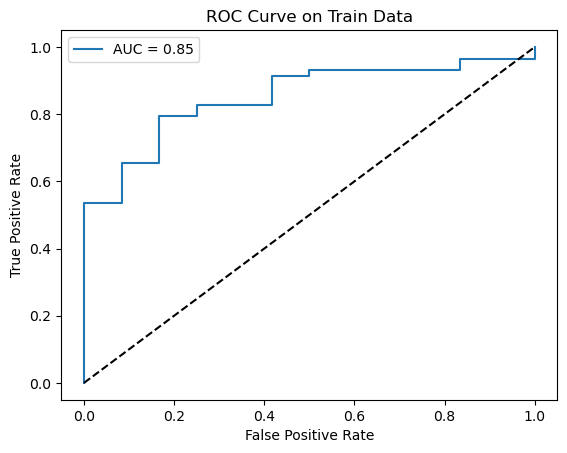

In [60]:
# Вычисление вероятностей принадлежности к положительному классу
y_train_prob = lr.predict_proba(X_train_scaled)[:, 1]

# Вычисление FPR и TPR
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob)

# Вычисление площади под ROC-кривой (AUC)
auc_train = roc_auc_score(y_train, y_train_prob)

# Построение ROC-кривой
plt.plot(fpr_train, tpr_train, label=f"AUC = {auc_train:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Train Data')
plt.legend()
plt.show()

Эта кривая может дать представление о том, насколько хорошо модель поддалась обучению на наборе данных.

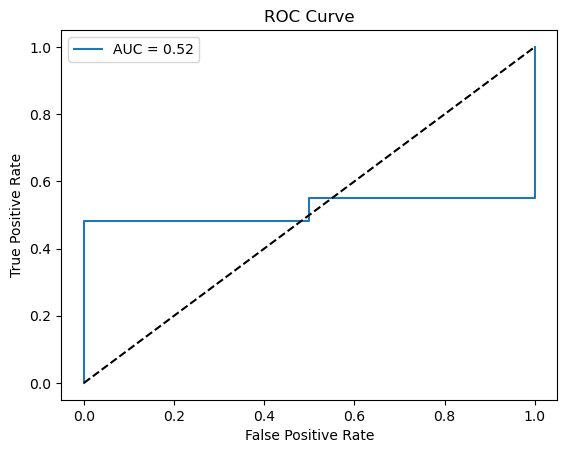

In [61]:
# Вычисление вероятностей принадлежности к положительному классу
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

# Вычисление FPR и TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Вычисление площади под ROC-кривой (AUC)
auc = roc_auc_score(y_test, y_prob)

# Построение ROC-кривой
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

На обучающей выборке мы видим довольно высокое значение AUC, но вот на\
тестовом наборе данных наша модель ведет себя почти так же, как и случайный выбор.

## Вывод

При выполнении работы я построила несколько моделей машинного обучения для анализа валютного датасета с высокой частотой дискретизации, которые выполняли разные функции в разных режимах: режим торгов, режим предсказания, режим классификации.
Сравнивая эти модели, я могу сказать, что модель логистической регрессии показала наиболее удовлетворительные результаты работы на нашем наборе данных, нежели остальные модели.

Модель логистической регрессии, которая получает на вход предыдущие значения цены и объема торгов, имеет достаточно высокие показатели качества, но если применить эту модель для набора данных, который создаёт условия торгов на фондовом рынке, значения метрик сильно падают.

Точность такой модели составляет примерно 55%, что является неэффективным. Таким образом, все модели машинного обучения для предсказания цены или ее направления на фондовом рынке сильно переобучаются, построение ROC-кривой для модели логистической регрессии подтверждает мои рассуждения. На тестовых данных кривая имеет AUC, почти совпадающий с AUC при случайном выборе. В конечном итоге, построенные модели не применимы на практике.